Train separate models on 0.4 iid training set sampled from each of G1 and G2; evaluate LLC on intersection of G1 and G2's multiplication tables

In [3]:
import sys
import torch as t
import numpy as np
from matplotlib import pyplot as plt
import json
from itertools import product
sys.path.append('/workspace/wilson/Finite-groups/src')
from model import MLP3, MLP4, InstancedModule
from utils import *
from group_data import *
from model_utils import *
from group_utils import *
from jaxtyping import Float
from typing import Union
from einops import repeat
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import copy
import math
from itertools import product
from llc import *
%load_ext autoreload
%autoreload 2

In [4]:
llc_params = {
    'eps': 8e-4,
    'beta': 1e3,
    'gamma': 1.,
    'chains': 5,
    'cbatch_size': 5,
    'replacement': False,
    'behavioral': True,
    'epochs': 3000,
}

In [5]:
paths = {
    'Z(48,2)': '/workspace/models/2024_07_31_03_48_41_Z_48_2__long',
    'twZ(48)': '/workspace/models/2024_07_31_04_29_56_twZ_48__long'
}
# paths = {
#     'S(5)': '/workspace/models/2024-08-12_20-25-17_S_5_',
#     'times(A(5),Z(2))': '/workspace/models/2024-08-12_20-49-30_times_A_5__Z_2__',
# }
# paths = {
#     'Z(100)': '/workspace/models/2024-08-12_21-54-36_Z_100_',
#     'Z(50,2)': '/workspace/models/2024-08-12_21-58-28_Z_50_2_',
# }
# paths = {
#     'abFam(5,7)[0]': '/workspace/models/2024-08-12_23-40-42_abFam_5_7__0_',
#     'abFam(5,7)[1]': '/workspace/models/2024-08-12_23-55-03_abFam_5_7__1_',
# }


In [40]:
params

Parameters(instances=100, embed_dim=32, hidden_size=64, epochs=20000, batch_size=64, batched=False, activation='relu', weight_decay=0.0002, lr=0.01, beta1=0.9, beta2=0.98, optimizer='adam', checkpoint=3, name='twZ(48)_long', seed=42, group_string='Z(48,2);twZ(48)', intersect_frac=1.0, delta_frac=[0.0, 0.0], train_frac=1.0, save_weights=False, load_weights='', wandb=True, thresh_grok=0.95, project='group generalization', model='MLP3', unembed_bias=False, init_func='kaiming_uniform', correct_embed=False)

In [6]:
model_dict = {}
for k, path in paths.items():
    models, params = load_models(path)
    model_dict[k] = models[-1]

In [7]:
params.group_string = ';'.join(paths.keys())
params.train_frac = 1.
params.delta_frac = [0.] * len(model_dict)
dataset = GroupData(params)

Intersection size: 6912/9216 (0.75)
Added 6912 elements from intersection
Added 0 elements from group 0: Z(48,2)
Added 0 elements from group 1: twZ(48)
Train set size: 6912/9216 (0.75)


In [8]:
llc_dict = {k: get_llc(model.to(device), dataset, **llc_params)[0] for k, model in model_dict.items()}

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

SGLD:   0%|          | 0/3000 [00:00<?, ?it/s]

In [9]:
loss_dict = {k: full_train_loss(model, dataset) for k, model in model_dict.items()}

In [10]:
min_llc = min([llc.min() for llc in llc_dict.values()]).item()
max_llc = max([llc.max() for llc in llc_dict.values()]).item()
min_loss = min([loss.min() for loss in loss_dict.values()]).item()
max_loss = max([loss.max() for loss in loss_dict.values()]).item()

In [11]:
min_llc, max_llc, min_loss, max_loss

(1057.285400390625, 2139.27734375, 0.02695544809103012, 0.12449735403060913)

In [22]:
llc_dict = {
    'Z/48Z × Z/2Z': llc_dict['Z/48Z x Z/2Z'],
    'Z/48Z ⋊ Z/2Z': llc_dict['Z/48Z ⋊ Z/2Z'],
}

In [23]:
llc_xbins = dict(
    start=min_llc,
    end=max_llc,
    size=100,
)
loss_xbins = dict(
    start=min_loss,
    end=max_loss,
    size=1e-2,
)
llc_data = []
loss_data = []
colors = ['blue', 'red', 'green', 'orange', 'magenta', 'yellow']
for color, (k, llc), (l, loss) in zip(colors, llc_dict.items(), loss_dict.items()):
    llc_data.append(go.Histogram(
        x=llc.tolist(),
        opacity=0.5,
        name=k,
        marker=dict(color=color),
        xbins=llc_xbins,
    ))
    loss_data.append(go.Histogram(
        x=loss.tolist(),
        opacity=0.5,
        name=l,
        marker=dict(color=color),
        xbins=loss_xbins,
    ))

llc_layout = go.Layout(
    title='bLLCs on intersection',
    barmode='overlay'
)
loss_layout = go.Layout(
    title='intersect loss',
    barmode='overlay'
)
llc_fig = go.Figure(data=llc_data, layout=llc_layout)
loss_fig = go.Figure(data=loss_data, layout=loss_layout)

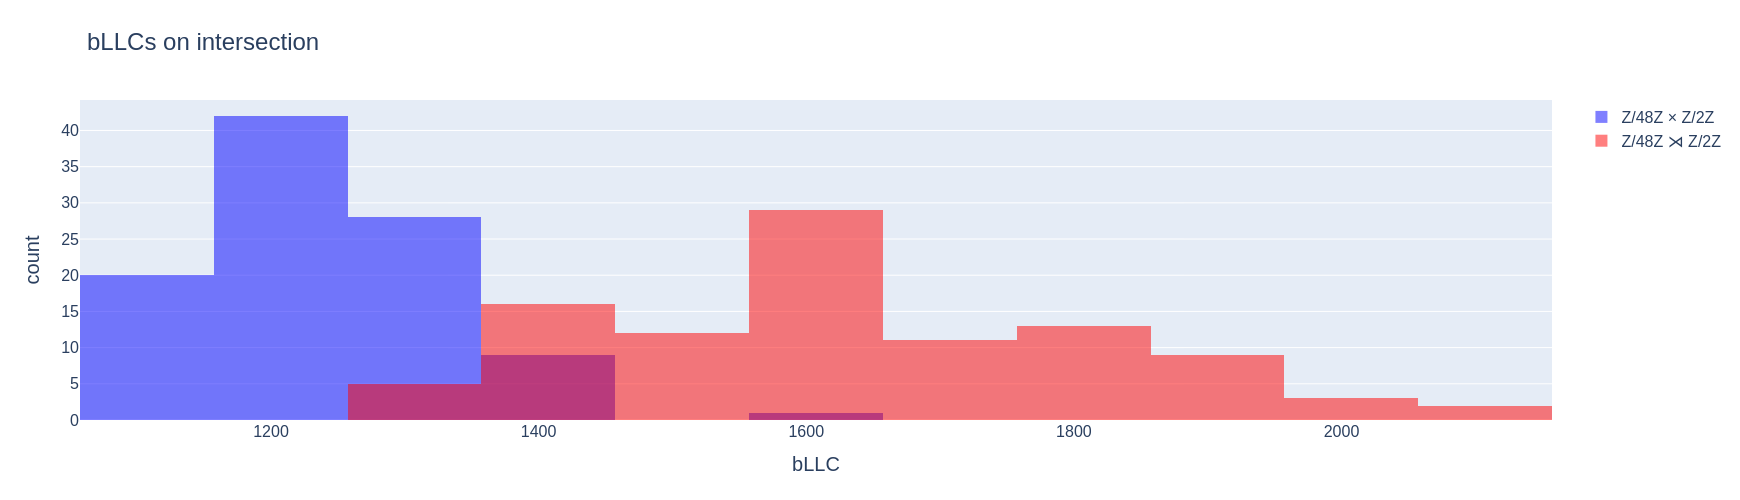

In [39]:
llc_fig.update_layout(
    dict(
        width=1600,height=500,
        xaxis=dict(title='bLLC', tickfont=dict(size=16), titlefont=dict(size=20)),
        yaxis=dict(title='count', tickfont=dict(size=16), titlefont=dict(size=20)),
        title=dict(text="bLLCs on intersection", font=dict(size=24)),
        legend=dict(
            font=dict(size=16)  # Legend font size
        )
    )
)
llc_fig.show()

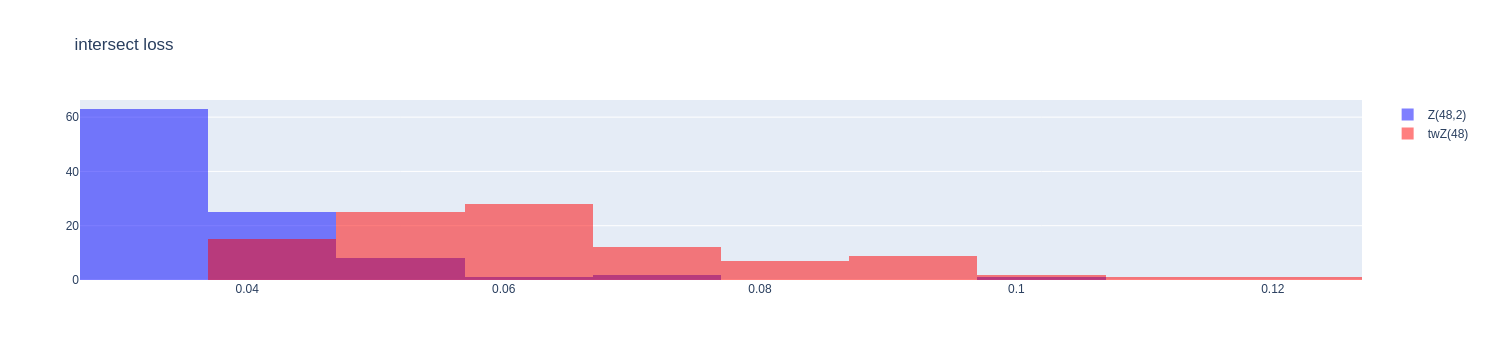

In [16]:
loss_fig.show()

In [41]:
#path = '/workspace/models/2024-08-13_01-57-27_abFam_5_7_'
#path = '/workspace/models/2024-08-13_03-06-33_S_5__times_A_5__Z_2__'
path = '/workspace/wilson/Finite-groups/models/2024-08-21_00-34-13_Z_48_2__twZ_48_'
models, params = load_models(path)

In [42]:
dataset = GroupData(params)

Intersection size: 6912/9216 (0.75)
Added 6912 elements from intersection
Added 0 elements from group 0: Z(48,2)
Added 0 elements from group 1: twZ(48)
Train set size: 6912/9216 (0.75)


In [55]:
loss_dict = test_loss(models[0].to(device), dataset)
min_loss = min([loss_dict[f'G{i}_loss'].min() for i in range(len(dataset.groups))])
max_loss = max([loss_dict[f'G{i}_loss'].max() for i in range(len(dataset.groups))])

In [56]:
loss_xbins = dict(
    start=min_loss,
    end=max_loss,
    size=3e-1,
)
loss_data = []
colors = ['blue', 'red', 'green', 'orange', 'magenta', 'yellow']
for i, color in zip(range(len(dataset.groups)), colors):
    loss_data.append(go.Histogram(
        x=loss_dict[f'G{i}_loss'].tolist(),
        opacity=0.5,
        name=dataset.groups[i].name,
        marker=dict(color=color),
        xbins=loss_xbins,
    ))


loss_layout = go.Layout(
    title='test loss',
    barmode='overlay'
)
loss_fig = go.Figure(data=loss_data, layout=loss_layout)

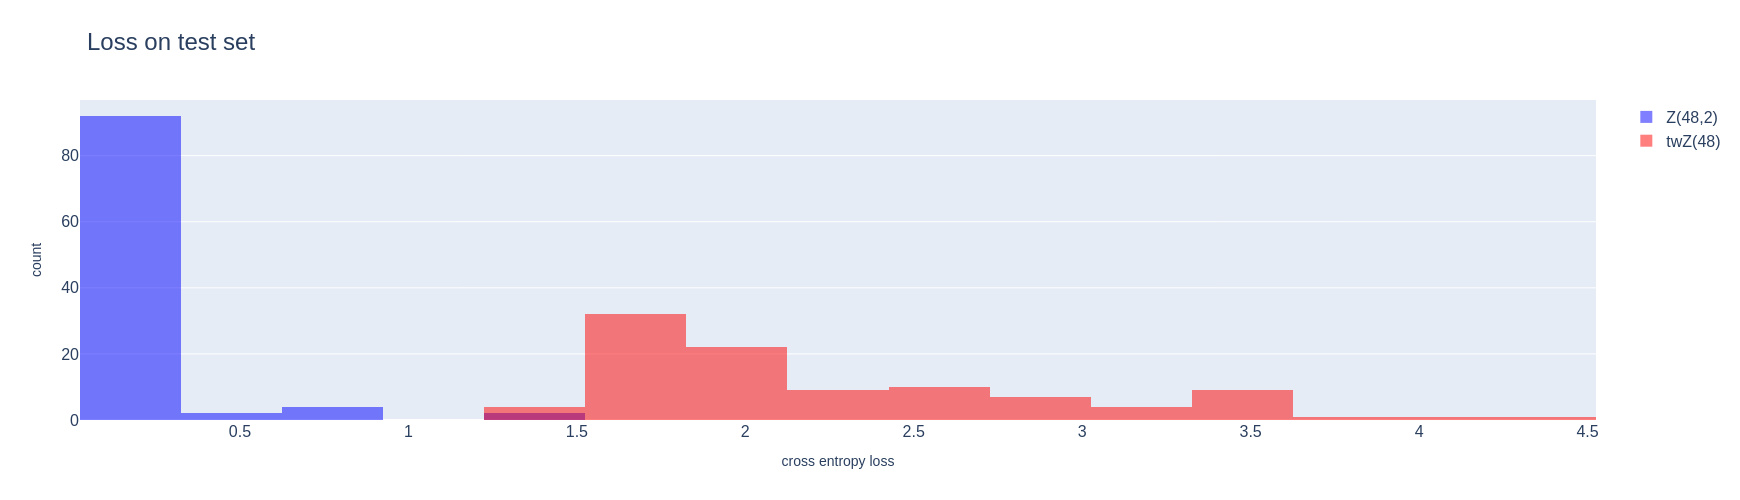

In [59]:
loss_fig.update_layout(
    dict(
        width=1600,height=500,
        xaxis=dict(title='cross entropy loss', tickfont=dict(size=16), titlefont=dict(size=20)),
        yaxis=dict(title='count', tickfont=dict(size=16), titlefont=dict(size=20)),
        title=dict(text="Loss on test set", font=dict(size=24)),
        legend=dict(
            font=dict(size=16)  # Legend font size
        )
    )
)
loss_fig.show()

In [14]:
max_loss

tensor(3.9959, device='cuda:0')